Training The Network:
EPOCH: 1/40
Train loss: 2.070246, Train accuracy: 0.2799
Val loss: inf, Val accuracy: 0.2581
EPOCH: 2/40
Train loss: 2.002571, Train accuracy: 0.3274
Val loss: inf, Val accuracy: 0.2823
EPOCH: 3/40
Train loss: 1.991202, Train accuracy: 0.3373
Val loss: inf, Val accuracy: 0.3226
EPOCH: 4/40
Train loss: 1.974499, Train accuracy: 0.3353
Val loss: inf, Val accuracy: 0.3548
EPOCH: 5/40
Train loss: 1.941947, Train accuracy: 0.3640
Val loss: inf, Val accuracy: 0.3952
EPOCH: 6/40
Train loss: 1.923434, Train accuracy: 0.3808
Val loss: inf, Val accuracy: 0.4113
EPOCH: 7/40
Train loss: 1.914088, Train accuracy: 0.3808
Val loss: inf, Val accuracy: 0.4113
EPOCH: 8/40
Train loss: 1.881569, Train accuracy: 0.4045
Val loss: inf, Val accuracy: 0.3952
EPOCH: 9/40
Train loss: 1.883150, Train accuracy: 0.3877
Val loss: inf, Val accuracy: 0.3790
EPOCH: 10/40
Train loss: 1.867350, Train accuracy: 0.4085
Val loss: inf, Val accuracy: 0.4032
EPOCH: 11/40
Train loss: 1.858444, Train accura

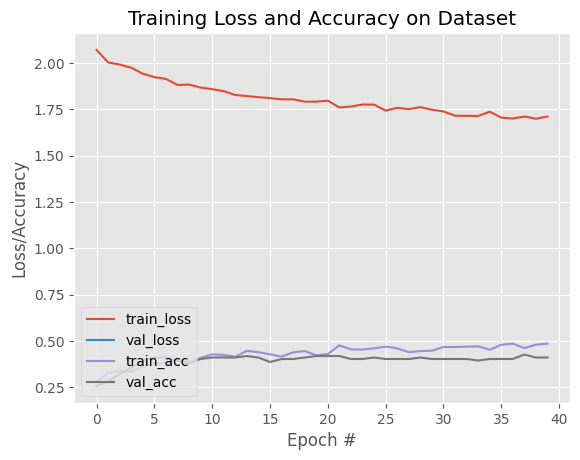

In [13]:
import torch
import os
from torch.utils.data import DataLoader
from torchvision import datasets
from imutils import paths
import numpy as np
import shutil
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
import time

# define paths
TRAIN = "/content/drive/MyDrive/Colab Notebooks/dataset/train"
VAL = "/content/drive/MyDrive/Colab Notebooks/dataset/val"
TEST = "/content/drive/MyDrive/Colab Notebooks/dataset/test"


# define ImageNet parameters
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
# determine the device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# define training hyperparameters
FEATURE_EXTRACTION_BATCH_SIZE = 256
PRED_BATCH_SIZE = 4
EPOCHS = 40
LR = 0.001
LR_FINETUNE = 0.0005

def get_dataloader(rootDir, transforms, batchSize, shuffle=True):
	# create a dataset and use it to create a data loader
	ds = datasets.ImageFolder(root=rootDir,
		transform=transforms)
	loader = DataLoader(ds, batch_size=batchSize,
		shuffle=shuffle,
		num_workers=os.cpu_count(),
		pin_memory=True if DEVICE == "cuda" else False)
	return (ds, loader)
 

  
# define transformation parameters
trainTansform = transforms.Compose([
	transforms.RandomResizedCrop(IMAGE_SIZE),
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(90),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])
valTransform = transforms.Compose([
	transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
	transforms.ToTensor(),
	transforms.Normalize(mean=MEAN, std=STD)
])

# create data loaders
(trainDS, trainLoader) = get_dataloader(TRAIN,
	transforms=trainTansform,
	batchSize=FEATURE_EXTRACTION_BATCH_SIZE)
(valDS, valLoader) = get_dataloader(VAL,
	transforms=valTransform,
	batchSize=FEATURE_EXTRACTION_BATCH_SIZE, shuffle=False)
testTransform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
(testDS, testLoader) = get_dataloader(TEST,
                                        transforms=testTransform,
                                        batchSize=PRED_BATCH_SIZE,
                                        shuffle=False)

# load up the ResNet50 model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
# set the model parameters to not be trained
for param in model.parameters():
	param.requires_grad = False
# add new layer for classifying
modelOUTPUTFeats = model.fc.in_features
model.fc = nn.Linear(modelOUTPUTFeats, len(trainDS.classes))
model = model.to(DEVICE)
# initialize loss function and optimizer
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.fc.parameters(), lr=LR)
trainSteps = len(trainDS) // FEATURE_EXTRACTION_BATCH_SIZE
valSteps = len(valDS) // FEATURE_EXTRACTION_BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],
	"val_acc": []}

# loop epochs
print("Training The Network:")
for e in range(EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions
	trainCorrect = 0
	valCorrect = 0
	# loop the training set
	for (i, (x, y)) in enumerate(trainLoader):
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
		# forward pass to calculate the training loss
		pred = model(x)
		loss = lossFunc(pred, y)
		# calculate the gradients
		loss.backward()
		if (i + 2) % 2 == 0:
			opt.step()
			opt.zero_grad()
	  #sum the loss
		totalTrainLoss += loss
		#calculate number of correct predictions
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()
   
	# switch off autograd
	with torch.no_grad():
		# set the model to evaluation mode
		model.eval()
		# loop the validation set
		for (x, y) in valLoader:
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			pred = model(x)
			totalValLoss += lossFunc(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()

    
	# calculate average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate training and validation accuracy
	trainCorrect = trainCorrect / len(trainDS)
	valCorrect = valCorrect / len(valDS)
	# update the training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the training and validation information
	print("EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
		avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
		avgValLoss, valCorrect))

# plot
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

# set the model in evaluation mode
model.eval()
# initialize number of correct predictions for the test set
testCorrect = 0
# loop over the test set
for images, labels in testLoader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    # forward pass
    preds = model(images)
    # get the index of the predicted class
    _, predicted = torch.max(preds.data, 1)
    # add correct predictions to the total count
    testCorrect += (predicted == labels).sum().item()
# calculate test accuracy
testAcc = testCorrect / len(testDS)
H["test_acc"] = testAcc
print(f"Test Accuracy: {testAcc:.2f}")